## Best model

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np

In [3]:
path = '../thermofeeler/data/tokenized_dataset.csv'
df = pd.read_csv(path)

In [4]:
df = df.drop(columns=['Unnamed: 0'])
df_pos = df[df.encoded_sentiment == 1][:7000]
df_neg = df[df.encoded_sentiment == -1][:7000]
df_net = df[df.encoded_sentiment == 0][:7000]

In [5]:
small_df = pd.concat([df_pos, df_neg, df_net])

In [6]:
X = small_df.tweet_text
y = small_df.encoded_sentiment
y = pd.get_dummies(y)

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7, random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14699,), (6301,), (14699, 3), (6301, 3))

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
tk = Tokenizer()
tk.fit_on_texts(X_train)
X_train_token = tk.texts_to_sequences(X_train)
X_train_token[0]

[3, 61, 121, 62, 87, 603, 470, 100, 2546, 67, 1720, 752, 192, 817]

In [10]:
maxLength = max(len(x) for x in X_train_token)
minLength = min(len(x) for x in X_train_token)
vocab_size = len(tk.word_index)
maxLength, minLength, vocab_size

(41, 0, 24625)

In [11]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
X_train_pad = pad_sequences(X_train_token, dtype='int32', padding='post', value=0, maxlen=50 )
X_train_pad[0]

array([   3,   61,  121,   62,   87,  603,  470,  100, 2546,   67, 1720,
        752,  192,  817,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers

In [13]:
def initialize_model():
    
    reg_l1 = regularizers.L1(0.01)
    reg_l2 = regularizers.L2(0.01)
    reg_l1_l2 = regularizers.l1_l2(l1=0.01, l2=0.01)
    
    opt = optimizers.RMSprop(learning_rate=0.0001)
    
    model = Sequential()
    embedding_size = 200
    model.add(Embedding(input_dim = vocab_size+1, input_length=50,
                        output_dim=embedding_size, mask_zero=True))
    
    model.add(LSTM(50, activation='tanh'))
    model.add(Dropout(0.4))
    model.add(Dense(50, activation='relu', kernel_regularizer=reg_l2))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation="softmax", kernel_regularizer=reg_l2))
    
    model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

    return model

In [14]:
%%time
model = initialize_model()
es = EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(X_train_pad, y_train, epochs=200, batch_size=32, verbose=1, callbacks=[es], validation_split=0.2 );

2022-03-23 14:03:54.628569: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/200
368/368 [==============================] - 11s 24ms/step - loss: 1.5053 - accuracy: 0.5153 - val_loss: 1.2947 - val_accuracy: 0.6265
Epoch 2/200
368/368 [==============================] - 8s 22ms/step - loss: 1.1227 - accuracy: 0.6640 - val_loss: 0.9861 - val_accuracy: 0.6568
Epoch 3/200
368/368 [==============================] - 8s 22ms/step - loss: 0.8865 - accuracy: 0.6795 - val_loss: 0.7997 - val_accuracy: 0.6714
Epoch 4/200
368/368 [==============================] - 8s 22ms/step - loss: 0.7411 - accuracy: 0.6890 - val_loss: 0.6881 - val_accuracy: 0.6861
Epoch 5/200
368/368 [==============================] - 8s 22ms/step - loss: 0.6552 - accuracy: 0.7291 - val_loss: 0.6214 - val_accuracy: 0.7510
Epoch 6/200
368/368 [==============================] - 8s 23ms/step - loss: 0.5979 - accuracy: 0.7676 - val_loss: 0.5782 - val_accuracy: 0.7765
Epoch 7/200
368/368 [==============================] - 8s 23ms/step - loss: 0.5533 - accuracy: 0.7989 - val_loss: 0.5474 - val_accuracy

In [15]:
 model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 200)           4925200   
                                                                 
 lstm (LSTM)                 (None, 50)                50200     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 50)                2550      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 153       
                                                                 
Total params: 4,978,103
Trainable params: 4,978,103
Non-

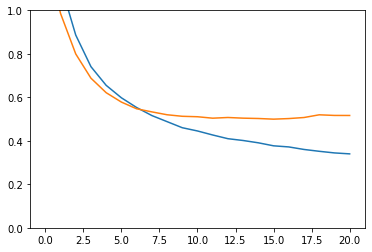

In [16]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim((0,1));

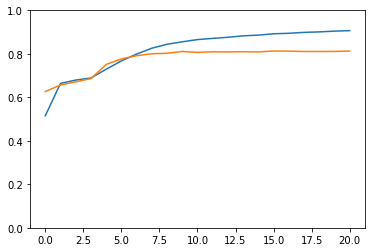

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim((0,1));

In [18]:
X_test_token = tk.texts_to_sequences(X_test)

In [19]:
X_test_pad = pad_sequences(X_test_token, dtype='int32', padding='post', value=0, maxlen=50 )
X_test_pad[0]

array([699,  16, 554, 158,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [20]:
model.evaluate(X_test_pad, y_test, verbose=0)

[0.4923836588859558, 0.8205046653747559]

## Vocab after advanced preprocessing

In [22]:
import re

In [ ]:
# Pattern matching for all case alphabets# Pattern matching for all case alphabets
Pattern_alpha = re.compile(r"([A-Za-z])\1{1,}", re.DOTALL)  
# Limiting all the  repeatation to two characters.
Formatted_tweet = Pattern_alpha.sub(r"\1\1", tweet)   # r'\1\1' --> It limits all the repeatation to two characters.
return Formatted_tweet

In [23]:
def remove_dupla(tweet):
    for word in tweet:
        let = word[:2]
        if word.count(let) >= 2: 
            tweet = let.sub(r'\2',tweet)
            tweet[tweet.index(word)] = word_
    return tweet

In [24]:
remove_dupla('hehehehehe')

'hehehehehe'

In [35]:
def strip_accents(s):
    return (''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn'))

In [36]:
strip_accents('éàlçâêô')

'ealcaeo'

In [ ]:
std_list = {'é':'ser','eh':'ser','vc':'voce','vcs':'voces','tb': 'tambem','tbm': 'tambem', 
            'obg': 'obrigado','obrigada':'obrigado','gnt': 'gente', 'q': 'que', 'n': 'nao', 
            'cmg': 'comigo', 'p':'para','pra' :'para','ta': 'está','tá':'está','to': 'estou', 
            'vdd':'verdade','bjos':'beijo','bjo':'beijo','kd': 'cade', 'pq':'porque',
            'cmg':'comigo','cm':'com','pc':'ca','aq':'aqui','qdo':'quando','p':'para','k':'que','agr':'agora'}

verb_list = {'sou':'ser','es':'ser','somos':'ser','sao':'ser','era':'ser','eras':'ser','era':'ser',
             'eramos':'ser','ereis':'ser','eram':'ser', 'fui':'ser', 'foste':'ser', 'foi':'ser','fomos':'ser',
             'fostes':'ser','foram':'ser','fora':'ser','foras':'ser','fôramos':'ser','foreis':'ser', 'serei':'ser',
             'sera':'ser','seremos':'ser','sereis':'ser','serao':'ser', 'seria':'ser','serias':'ser',
             'seriamos':'ser','serieis':'ser','seriam':'ser','seja':'ser','sejas':'ser','seja':'ser',
             'sejamos':'ser','sejais':'ser','sejam':'ser','fosse':'ser','fosses':'ser','fosse':'ser',
             'fossemos':'ser','fosseis':'ser','fossem':'ser',
             'estou':'estar', 'esta':'estar', 'estamos':'estar', 'estao':'estar', 'estive':'estar', 
             'esteve':'estar','estivemos':'estar','estiveram':'estar', 'estava':'estar', 'estavamos':'estar', 
             'estavam':'estar', 'estivera':'estar', 'estivéramos':'estar', 'esteja':'estar', 'estejamos':'estar', 
             'estejam':'estar','estivesse':'estar', 'estivessemos':'estar', 'estivessem':'estar','estiver':'estar',
             'estivermos':'estar','estiverem':'estar', 'estaremos':'estar',
             'havia':'haver', 'houveram':'haver',
             'hei':'haver','ha':'haver','havemos':'haver','hao':'haver', 'houve':'haver', 'houvemos':'haver', 
             'houveram':'haver', 'houvera':'haver', 'houveramos':'haver', 'haja':'haver','hajamos':'haver', 
             'hajam':'haver', 'houvesse':'haver', 'houvessemos':'haver', 'houvessem':'haver', 'houver':'haver', 
             'houvermos':'haver', 'houverem':'haver','houverei':'haver', 'houveremos':'haver',
             'houverao':'haver', 'houveria':'haver', 'houveriamos':'haver', 'houveriam':'haver',
             'tenho':'ter', 'temos':'ter','tinha':'ter', 'tinhamos':'ter', 'tinham':'ter', 'tive':'ter', 
             'teve':'ter', 'tivemos':'ter', 'tiveram':'ter', 'tivera':'ter','tiveramos':'ter','tenha':'ter',
             'tenhamos':'ter', 'tenham':'ter', 'tivesse':'ter', 'tivessemos':'ter', 
             'tivessem':'ter', 'tiver':'ter', 'tivermos':'ter', 'tiverem':'ter', 'terei':'ter', 'tera':'ter',
             'teremos':'ter', 'terao':'ter', 'teria':'ter', 'teriamos':'ter', 'teriam':'ter', 'tem':'ter',
             'deve':'dever', 'devem':'dever', 'devendo':'dever', 'devera':'dever', 'deverao':'dever', 
             'deveria':'dever', 'deveriam':'dever', 'devia':'dever', 'deviam':'dever',
             'faz':'fazer','fazeis':'fazer','fazem':'fazer','fazemos':'fazer','fazendo':'fazer','fazes':'fazer',
             'faço':'fazer','fazia':'fazer','fazias':'fazer','fazia':'fazer','faziamos':'fazer','fazieis':'fazer',
             'faziam':'fazer','farei':'fazer','faras':'fazer','fara':'fazer','faremos':'fazer',
             'fareis':'fazer','farao':'fazer','faça':'fazer','faças':'fazer','faça':'fazer','façamos':'fazer',
             'façais':'fazer','façam':'fazer','fizesse':'fazer',
             'fizesses':'fazer','fizesse':'fazer','fizessemos':'fazer','fizesseis':'fazer','fizessem':'fazer',
             'quero':'querer','queres':'querer','quer':'querer','queremos':'querer','quereis':'querer',
             'querem':'querer','queria':'querer','querias':'querer','queria':'querer','queriamos':'querer',
             'querieis':'querer','queriam':'querer'}


In [ ]:
def remove_abbreviation(tweet):
    for word in tweet:
        if word in std_list.keys():
            word_ = std_list[word]
            tweet[tweet.index(word)] = word_
    return tweet

In [ ]:
def remove_conjugaison(tweet):
    for word in tweet:
        if word in verb_list.keys():
            word_ = verb_list[word]
            tweet[tweet.index(word)] = word_
    return tweet

In [28]:
def lemmatization(tweet):
    lemma = ""
    for sent in nlp(tweet).sentences:
        for word in sent.words:
            lemma += word.lemma + " "
    return lemma

In [29]:
import re
from nltk.tokenize import word_tokenize
import pandas as pd
import unicodedata
import stanza

stanza.download('pt')
nlp = stanza.Pipeline('pt')

2022-03-23 15:46:32 INFO: Downloading default packages for language: pt (Portuguese)...
2022-03-23 15:46:33 INFO: File exists: /Users/laurannefossat/stanza_resources/pt/default.zip.
2022-03-23 15:46:34 INFO: Finished downloading models and saved to /Users/laurannefossat/stanza_resources.
2022-03-23 15:46:34 INFO: Loading these models for language: pt (Portuguese):
| Processor | Package |
-----------------------
| tokenize  | bosque  |
| mwt       | bosque  |
| pos       | bosque  |
| lemma     | bosque  |
| depparse  | bosque  |

2022-03-23 15:46:34 INFO: Use device: cpu
2022-03-23 15:46:34 INFO: Loading: tokenize
2022-03-23 15:46:34 INFO: Loading: mwt
2022-03-23 15:46:34 INFO: Loading: pos
2022-03-23 15:46:34 INFO: Loading: lemma
2022-03-23 15:46:34 INFO: Loading: depparse
2022-03-23 15:46:34 INFO: Done loading processors!


In [ ]:
def preproc_func(tweet):
    '''Does the preprocessing of the tweets'''
    
    tweet = tweet.lower() # lowercase
    
    tweet=re.sub('https?://[A-Za-z0-9./]+','',tweet) # remove links que começam com https?://
    tweet=re.sub('https://[A-Za-z0-9./]+','',tweet) # remove links que começam com https://
    tweet=re.sub('http://[A-Za-z0-9./]+','',tweet) # remove links que começam com http://
    
    tweet = re.sub(r'@[A-Za-z0-9_]+','',tweet) # remove @mentions
    tweet = re.sub(r'#',' ',tweet) # remove #hashtags
    
    tweet = re.sub(r'[^\w\s]','',tweet) # remove punctuation
    tweet = re.sub(r'[0-9]',' number',tweet) # remove numbers
    
    print('lemmatization')
    tweet = lemmatization(tweet)
    tweet = strip_accents(tweet) # remove accents
    print('tokenize')
    word_tokens=word_tokenize(tweet) # tokenize
    
    word_tokens = remove_onomatopeia(word_tokens) # remove onomatopeias
    word_tokens = remove_abbreviation(word_tokens) # remove abbreviations
    word_tokens = remove_conjugaison(word_tokens) # remove conjugaisons
    
    # stopwords: remove articles, prepositions, conjunctions etc
    stopwords=['a','ah','g','h', 'd','ca','te','tu','tua','tuas','um','uma','voce','voces','vos', 'la','lo','lá',
               'as','ao','aos','aquela','aquelas','aquele','aqueles','aquilo','as','ate','com','como','da','das',
               'de','dela','delas','dele','deles','depois','do','dos','e','ela','elas','ele','eles','em','entre',
               'essa','essas','esse','esses','eu','for','isso','isto','já','lhe','lhes','me','mesmo','meu','meus',
               'minha','minhas','muito','na','nas','no','nos','nossa','nossas','nosso','nossos','num','numa',
               'nós','oh','o','os','para','pela','pelas','pelo','pelos','por','qual','quando','que','quem',
               'se','sem','seu','seus','somos','sou','sua','suas','so','tambem', 'mas','ou', 'nem', 
               'este','teu','teus','estes','estas','agora','ai','alem','algo','alguém','algum','ainda',
               'alguma','algumas','alguns', 'ali','ampla','amplas', 'amplo', 'amplos','ante', 'antes','apenas',
               'apoio','após','aqui','aquilo','assim','atrás','através','bastante','breve','cada', 'cedo', 'cento', 
               'certamente','certeza','cima','coisa','coisas','da','dao','daquela', 'daquelas','daquele',
               'daqueles','dentro','contudo','debaixo','demais','depois','desde','dessa','dessas','desse','desses',
               'desta','destas','deste','destes','embora','enquanto','entre','etc','feita','feitas','feito', 
               'feitos','for','fora','geral','grande','grandes','hoje', 'hora', 'horas', 'longe',
               'lugar', 'maior','maioria','mais','meio', 'menor', 'menos', 'mes', 'meses','mesma', 'mesmas',
               'mesmo', 'mesmos','muita', 'muitas','muito','muitos','naquela', 'naquelas', 'naquele', 'naqueles',
               'nessa', 'nessas', 'nesse', 'nesses', 'nesta', 'nestas', 'neste', 'nestes','num', 'numa','onde',
               'ontem','perto','parte','outra', 'outras', 'outro', 'outros', 'pois', 'porém', 'porque',
               'possivel', 'possivelmente','pouca', 'poucas', 'pouco', 'poucos', 'primeira', 'primeiras',
               'primeiro', 'primeiros','propria','proprias','proprio', 'proprios', 'proxima', 'proximas',
               'proximo', 'proximos','quais', 'quanto', 'quantos','quem','sempre','si', 'sido','sob', 'sobre',
               'tal', 'talvez','tampouco', 'tanta', 'tantas','tanto', 'tao', 'tarde', 'te', 'todo', 'todos',
               'toda', 'todas','tudo', 'ultima', 'ultimas', 'ultimo', 'ultimos','vários','vez', 'vezes',]
    
    filtered_tweet = [w for w in word_tokens if not w in stopwords] # remove stopwords

    return filtered_tweet

In [ ]:
df_2 = pd.read_csv('../thermofeeler/data/encoded_df.csv')

In [ ]:
df_2.tweet_text.head()

In [ ]:
#df_2.tweet_text = df_2.tweet_text.apply(preproc_func)

In [ ]:
#df_2.tweet_text.head()

In [ ]:
df_2 = df_2.drop(columns=['Unnamed: 0'])
df_pos_2 = df_2[df_2.encoded_sentiment == 1][:1000]
df_neg_2 = df_2[df_2.encoded_sentiment == -1][:1000]
df_net_2 = df_2[df_2.encoded_sentiment == 0][:1000]

In [ ]:
small_df_2 = pd.concat([df_pos_2, df_neg_2, df_net_2])

In [ ]:
%%time
small_df_2.tweet_text = small_df_2.tweet_text.apply(preproc_func)

In [ ]:
X_2 = small_df_2.tweet_text
y_2 = small_df_2.encoded_sentiment
y_2 = pd.get_dummies(y_2)

In [ ]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2,y_2, train_size=0.7, random_state=1)

In [ ]:
tk_2 = Tokenizer()
tk_2.fit_on_texts(X_train_2)
X_train_token_2 = tk_2.texts_to_sequences(X_train_2)

In [ ]:
maxLength_2 = max(len(x) for x in X_train_token_2)
minLength_2 = min(len(x) for x in X_train_token_2)
vocab_size_2 = len(tk_2.word_index)
maxLength_2, minLength_2, vocab_size_2

In [ ]:
small_df_2.head()

In [ ]:
X_train_pad_2 = pad_sequences(X_train_token_2, dtype='int32', padding='post', value=0, maxlen=50)

In [ ]:
%%time
model = initialize_model()
es = EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(X_train_pad_2, y_train, epochs=200, batch_size=32, verbose=1, callbacks=[es], validation_split=0.2 );

In [ ]:
X_test_token_2 = tk_2.texts_to_sequences(X_test_2)
X_test_pad_2 = pad_sequences(X_test_token_2, dtype='int32', padding='post', value=0, maxlen=50 )

In [ ]:
model.evaluate(X_test_pad_2, y_test_2, verbose=0)

In [ ]:
preproc_func('@bkcfb oi ta tudo bem agr hello #feliz#good ., çêâ àé, amei amo sou é sera, amantes amigos amigas ')

In [ ]:
import re

In [39]:
t1 = '@bkcfb oi ta tudo bem agr hello #feliz#good ., çêâ àé,  amei amo sou é sera, està, amantes amigos amigas '

In [40]:
%%time
lista2 = t1+t1+t1+t1+t1+t1+t1+t1+t1+t1
t = lemmatization(lista2)
print(t)

@bkcfb oi er tudo bem agr hello #feliz#good . , dar àé , amar amar ser ser ser , estar , amante amigo amiga @bkcfb oi er tudo bem agr hello #feliz#good . , dar o aé , amar amar ser ser ser , estar , amante amigo amiga @bkcfb oi er tudo bem agr hello #feliz#good . , dar o aé , amar amar ser ser ser , estar , amante amigo amiga @bkcfb oi er tudo bem agr hello #feliz#good . , dar o aé , amar amar ser ser ser , estar , amante amigo amiga @bkcfb oi er tudo bem agr hello #feliz#good . , dar o aé , amar amar ser ser ser , estar , amante amigo amiga @bkcfb oi er tudo bem agr hello #feliz#good . , dar o aé , amar amar ser ser ser , estar , amante amigo amiga @bkcfb oi er tudo bem agr hello #feliz#good . , dar o aé , amar amar ser ser ser , estar , amante amigo amiga @bkcfb oi er tudo bem agr hello #feliz#good . , dar o aé , amar amar ser ser ser , estar , amante amigo amiga @bkcfb oi er tudo bem agr hello #feliz#good . , dar o aé , amar amar ser ser ser , estar , amante amigo amiga @bkcfb oi er

In [ ]:
lista = [t1,t1,t1,t1,t1,t1,t1,t1,t1,t1]

In [ ]:
%%time
for t in lista:
    t = lemmatization(t)
    print(t)

In [ ]:
t2 = ['@bkcfb' ,'oi', 'ta', 'tudo', 'bem agr hello #feliz#good ., çêâ àé,  amei amo sou é sera, està, amantes amigos amigas ']

In [ ]:
'@bkcfb  5546 #oi ta tudo bem agr hello #feliz#good amei amo sou é sera, amantes amigos amigas'